In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
# from numpy.fft import fft, fftfreq
from scipy.fft import fft, fftn, fftfreq
from scipy import stats
from scipy.signal import find_peaks, spectrogram, argrelmax
from scipy.interpolate import interp1d
from dtaidistance import dtw
import struct
sns.set()

In [2]:
# Load the dataset
file_path = "acquisitions/synthetic_test/processed/processed_all_actions.csv"

# Import the CSV file into a DataFrame
df = pd.read_csv(file_path)

# convert _time column to datetime
df['_time'] = pd.to_datetime(df['_time'])

In [3]:
# groupby by action
df_grouped = df.groupby('action')

# show all the actions
# print(df_grouped.groups.keys())

In [25]:
df_floatingx = df_grouped.get_group('floating_x')
df_hammerx = df_grouped.get_group('hammer_x')

In [5]:
def plot_sensors_df(df, title="", x_index='sample'):
    """
    Plot the sensors data in a 4x3 subplots
    """
    columns = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

    num_row = math.ceil(len(columns)/3)
    num_col = 3

    fig, axs = plt.subplots(num_row, num_col, figsize=(15, 10))
    fig.suptitle(title)

    for i, column in enumerate(columns):

        if x_index == 'sample':
            axs[i//3, i%3].plot(df[column], color='C'+str(i%3), label=column)
        else:
            axs[i//3, i%3].plot(df[x_index], df[column], color='C'+str(i%3), label=column)
            
        axs[i//3, i%3].legend()
        # axs[i//3, i%3].set_title(column)

        # set the y label
        if 'accel' in column:
            axs[i//3, i%3].set_ylabel('g')
        else:
            axs[i//3, i%3].set_ylabel('deg/s')

    # give more space between the subplots
    fig.tight_layout(pad=1.0)
    plt.show()

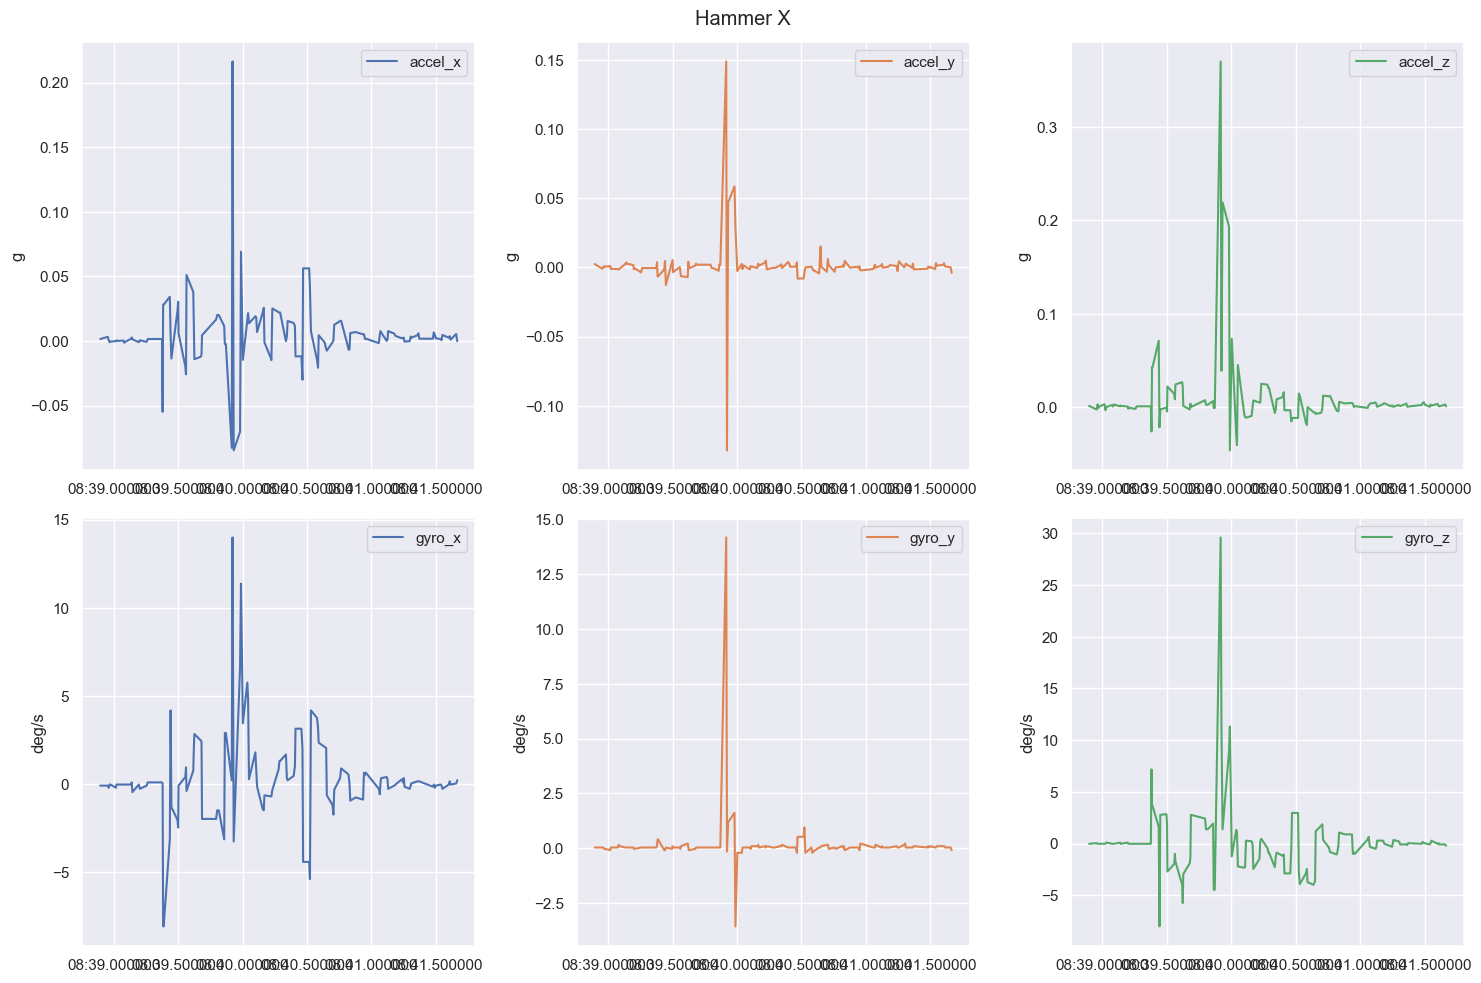

In [26]:
# plot_sensors_df(df_floatingx, "Floating X", x_index='_time')
plot_sensors_df(df_hammerx, "Hammer X", x_index='_time')

Re-sampling

In [27]:
# resample the dataset to 0.01s
sampling_time = 0.01
# keep only columns=['_time', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
df_floatinx_over = df_floatingx[['_time', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'quat_x', 'quat_y', 'quat_z', 'quat_w']].copy()
df_hammerx_over = df_hammerx[['_time', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'quat_x', 'quat_y', 'quat_z', 'quat_w']].copy()
# resample the dataset
df_floatinx_over = df_floatinx_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_hammerx_over = df_hammerx_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')

In [28]:
df_floatinx_over
df_hammerx_over

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,quat_x,quat_y,quat_z,quat_w
_time,,,,,,,,,,
2023-12-29 17:08:38.890,0.001514,0.002515,0.001270,-0.097561,0.030488,-0.024390,0.47,0.56,0.53,0.43
2023-12-29 17:08:38.900,0.001799,0.001945,0.000618,-0.097561,0.030488,-0.014228,0.47,0.56,0.53,0.43
2023-12-29 17:08:38.910,0.002083,0.001375,-0.000033,-0.097561,0.030488,-0.004065,0.47,0.56,0.53,0.43
2023-12-29 17:08:38.920,0.002368,0.000806,-0.000684,-0.097561,0.030488,0.006098,0.47,0.56,0.53,0.43
2023-12-29 17:08:38.930,0.002653,0.000236,-0.001335,-0.097561,0.030488,0.016260,0.47,0.56,0.53,0.43
...,...,...,...,...,...,...,...,...,...,...
2023-12-29 17:08:41.620,0.002124,0.000623,0.001270,-0.021341,0.030488,-0.085366,0.47,0.56,0.53,0.43
2023-12-29 17:08:41.630,0.003223,0.000439,0.001758,-0.006098,0.030488,-0.085366,0.47,0.56,0.53,0.43
2023-12-29 17:08:41.640,0.004321,0.000256,0.002246,0.009146,0.030488,-0.085366,0.47,0.56,0.53,0.43


In [75]:
def plot_fft_peaks(df, sampling_time):
    columns = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
    num_row = math.ceil(len(columns)/3)
    num_col = 3

    # create struct to return
    data_struct = {}

    fig, axs = plt.subplots(num_row, num_col, figsize=(15, 10))
    fig.suptitle("FFT with peaks")
    
    for i, column in enumerate(columns):
        # get the fft
        fft_values = fft(df[column].values)
        # get the frequency
        freq = fftfreq(len(df[column].values), d=sampling_time)
        # get the peaks
        peaks = argrelmax(np.abs(fft_values[freq>=0]), order=8)[0]
        # take the top 5 peaks which are greater than 0
        peaks = peaks[np.argsort(np.abs(fft_values[freq>=0][peaks]))[-5:]]
        # sort the peaks
        peaks.sort()
        # update the struct
        data_struct[column] = {'fft_values': fft_values, 'freq': freq, 'peaks': peaks}

        # plot the fft
        axs[i//3, i%3].plot(freq[freq>=0], np.abs(fft_values[freq>=0]), color='C'+str(i%3), label=column)
        # plot the peaks
        axs[i//3, i%3].plot(freq[peaks], np.abs(fft_values[freq>=0][peaks]), 'x', color='red', label='peaks')
        axs[i//3, i%3].legend()

        # set the y label
        if 'accel' in column:
            axs[i//3, i%3].set_ylabel('g')
        else:
            axs[i//3, i%3].set_ylabel('deg/s')
    
    return data_struct

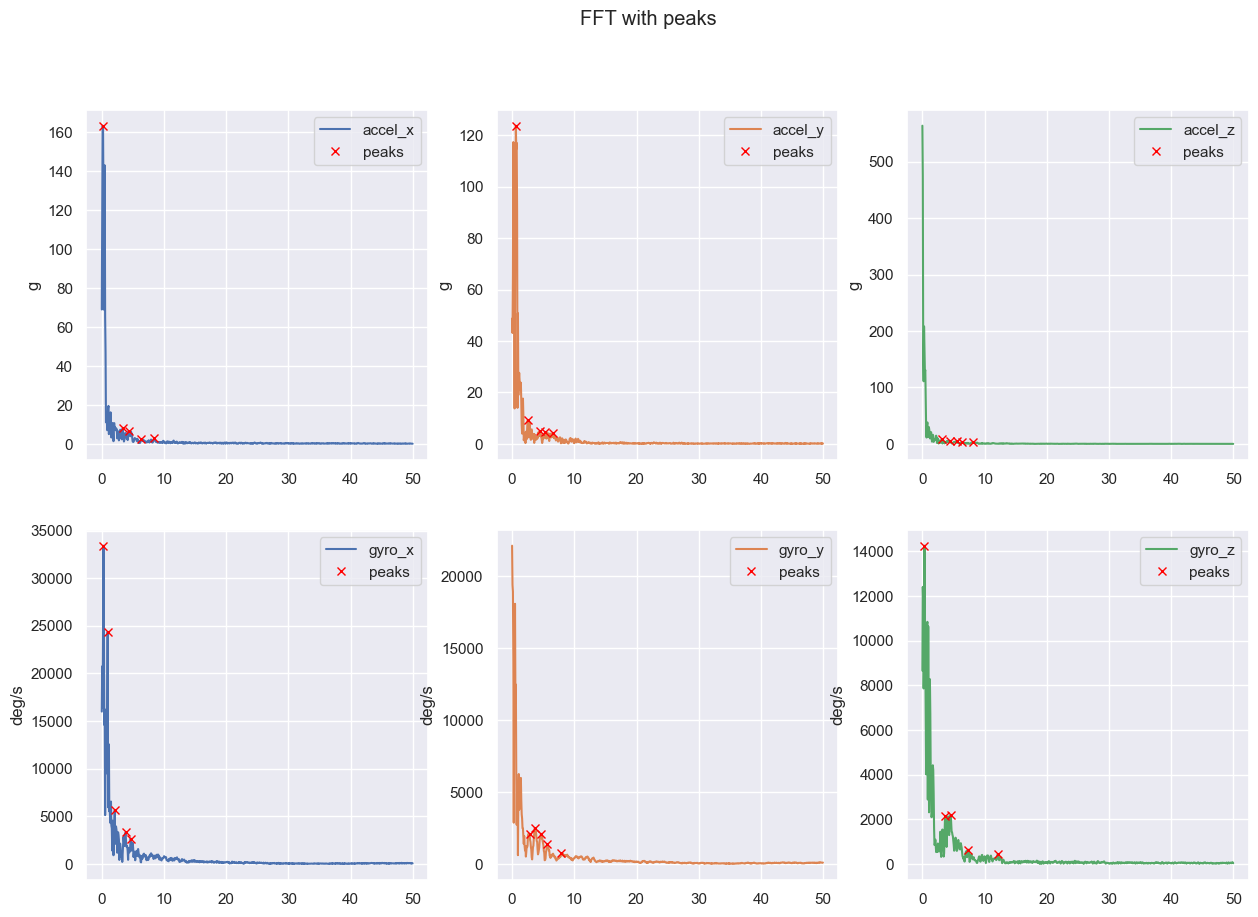

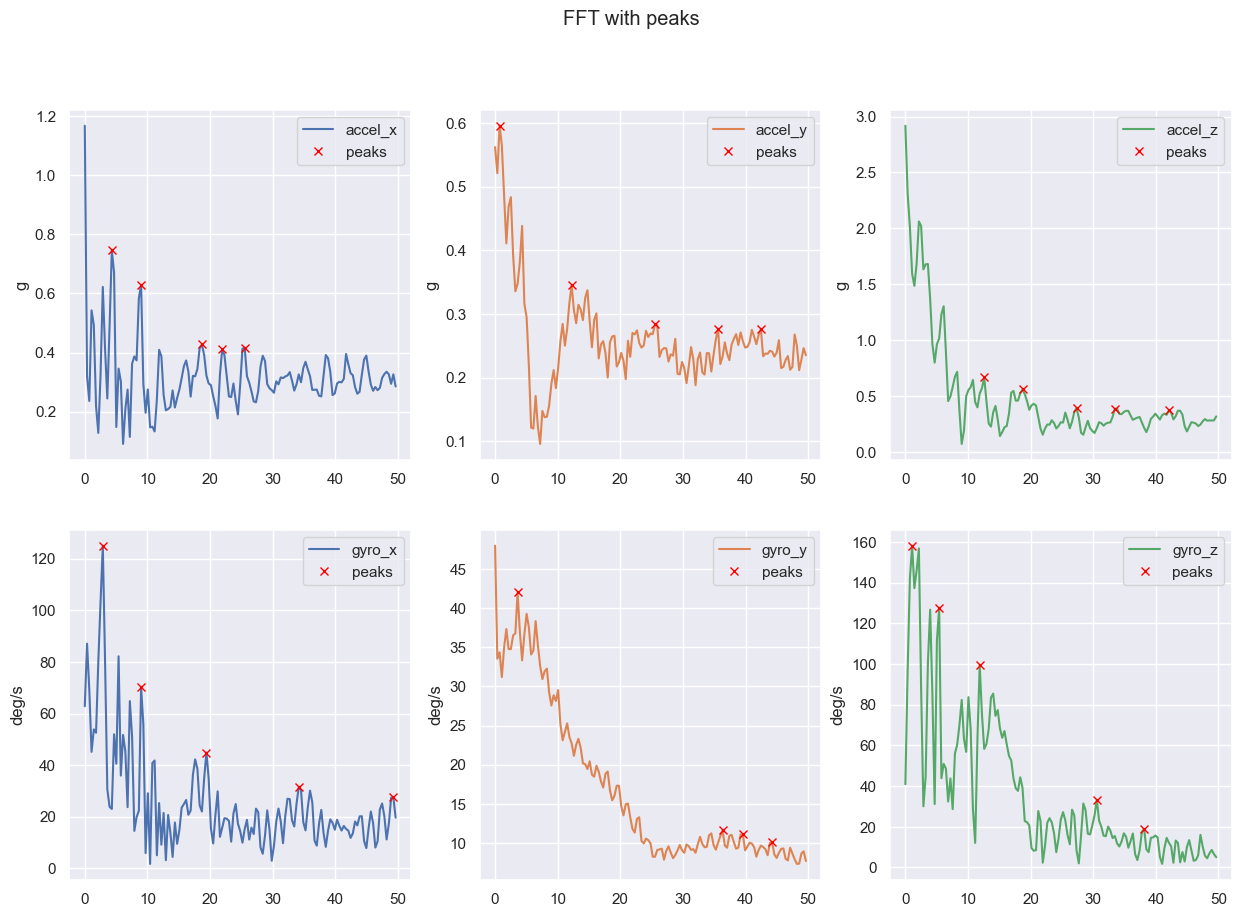

In [76]:
floatingx_fft = plot_fft_peaks(df_floatinx_over, sampling_time)
hammerx_fft = plot_fft_peaks(df_hammerx_over, sampling_time)

In [90]:
def plot_stem_peaks(sensor_fft, title=""):

    columns = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
    num_row = math.ceil(len(columns)/3)
    num_col = 3

    fig, axs = plt.subplots(num_row, num_col, figsize=(15, 10))
    fig.suptitle("FFT Peaks - "+title)

    for i, column in enumerate(columns):
        # stem plot
        axs[i//3, i%3].stem(sensor_fft[column]['freq'][sensor_fft[column]['peaks']], np.abs(sensor_fft[column]['fft_values'][sensor_fft[column]['peaks']]), label=column, basefmt='C'+str(i%3), linefmt='C'+str(i%3))
        axs[i//3, i%3].plot(sensor_fft[column]['freq'][sensor_fft[column]['peaks']], np.abs(sensor_fft[column]['fft_values'][sensor_fft[column]['peaks']]), label=column, color='C'+str(i%3), alpha=0.5)
        
        # set the y label
        if 'accel' in column:
            axs[i//3, i%3].set_ylabel('g')
        else:
            axs[i//3, i%3].set_ylabel('deg/s')
            axs[i//3, i%3].set_xlabel('Hz')

        axs[i//3, i%3].legend()


    # give more space between the subplots
    fig.tight_layout(pad=1.0)
    plt.show()

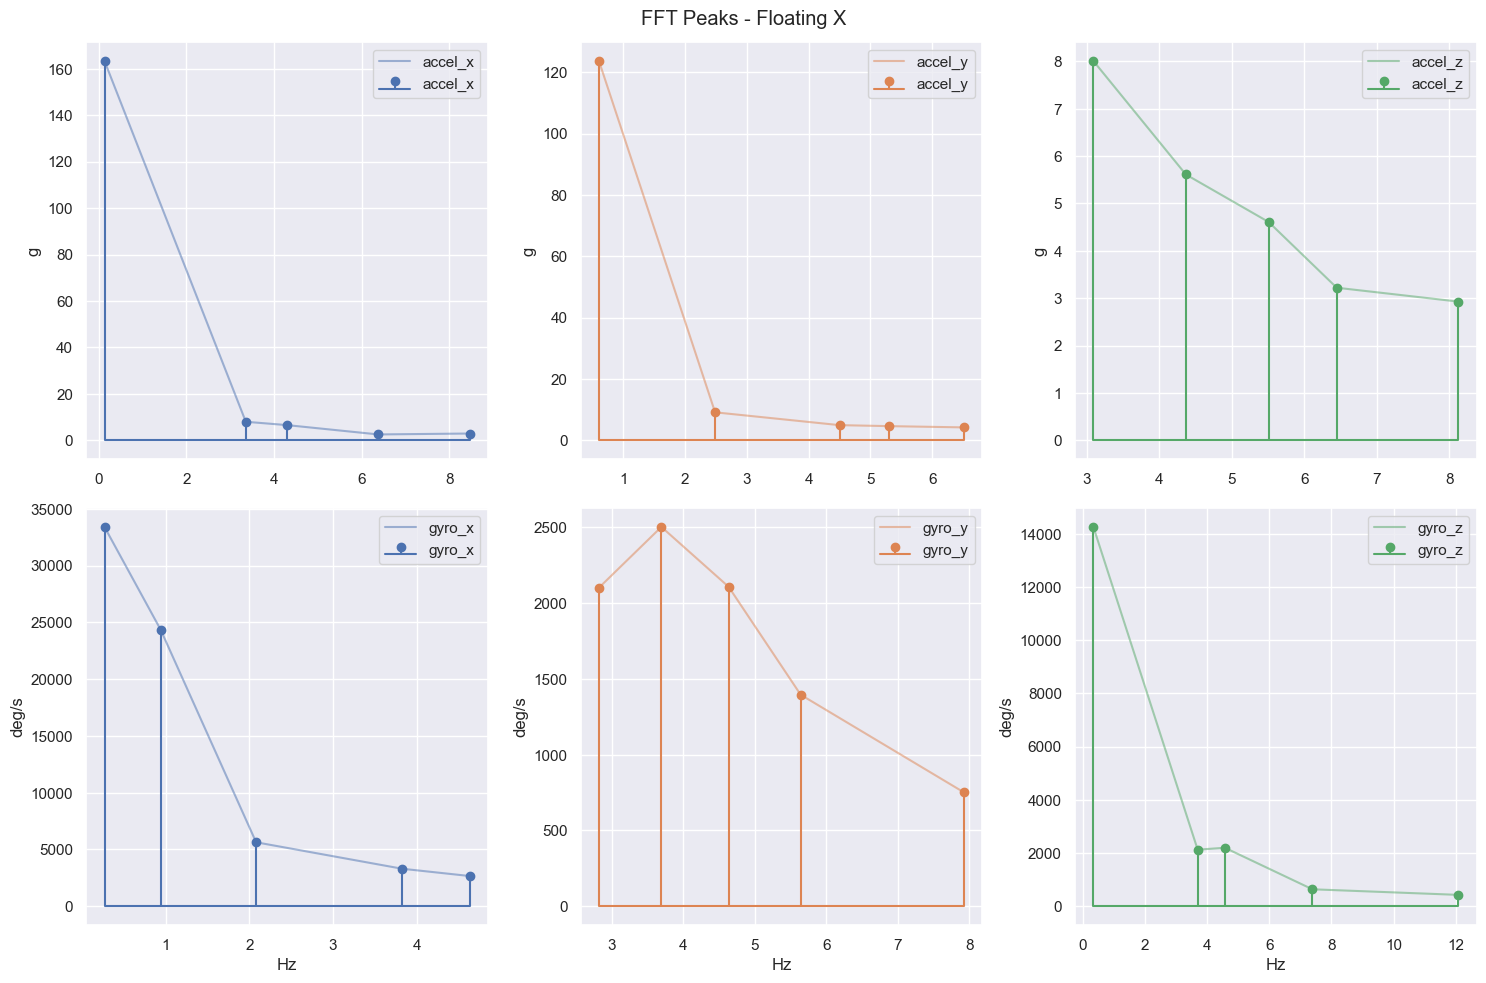

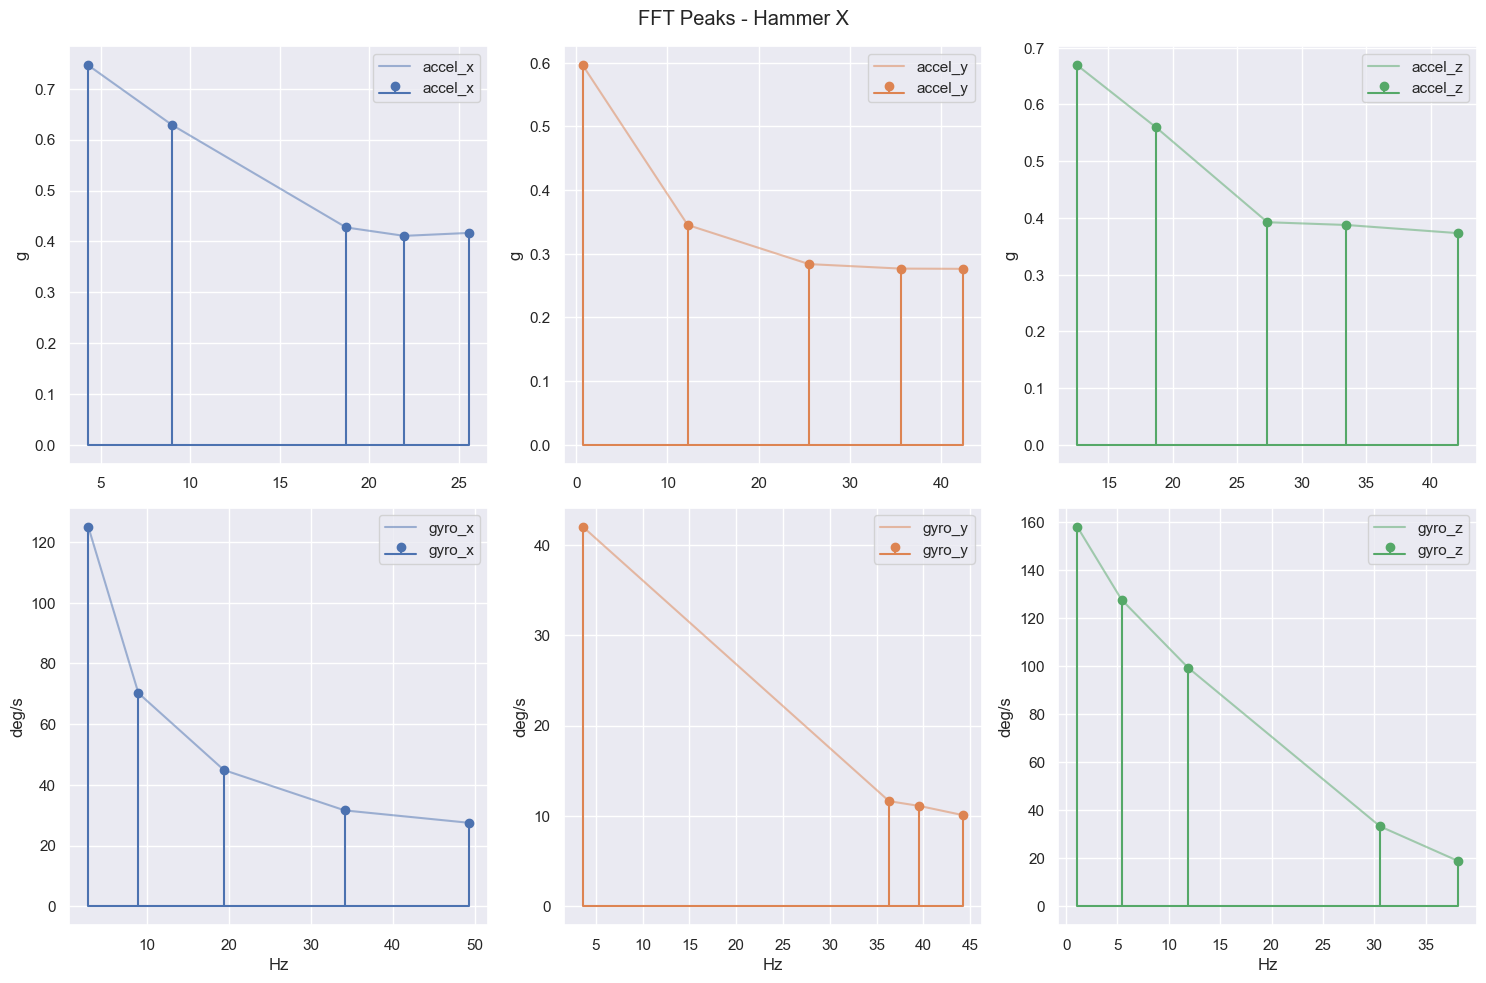

In [91]:
plot_stem_peaks(floatingx_fft, title="Floating X")
plot_stem_peaks(hammerx_fft, title="Hammer X")

In [116]:
def plot_peaks_combined(sensor_fft, title=""):

    columns = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
    num_row = math.ceil(len(columns)/3)
    num_col = 1

    fig, axs = plt.subplots(num_row, num_col, figsize=(15, 10))
    fig.suptitle("FFT Peaks Concatenated - "+title)

    accel_fft = []
    accel_freq = []
    gyro_fft = []
    gyro_freq = []

    for i, column in enumerate(columns):
        freq = sensor_fft[column]['freq'][sensor_fft[column]['peaks']]
        fft_values = np.abs(sensor_fft[column]['fft_values'][sensor_fft[column]['peaks']])
 
        # set the y label
        if 'accel' in column:
            accel_freq.append(freq)
            accel_fft.append(fft_values)
        else:
            gyro_freq.append(freq)
            gyro_fft.append(fft_values)

    # concat the accel and gyro
    accel_freq = np.concatenate(accel_freq)
    accel_fft = np.concatenate(accel_fft)
    gyro_freq = np.concatenate(gyro_freq)
    gyro_fft = np.concatenate(gyro_fft)
    
    # sort the accel and gyro
    accel = zip(accel_freq, accel_fft)
    gyro = zip(gyro_freq, gyro_fft)
    accel = sorted(accel, key=lambda x: x[0])
    gyro = sorted(gyro, key=lambda x: x[0])
    accel_freq, accel_fft = zip(*accel)
    gyro_freq, gyro_fft = zip(*gyro)

    # plot the accel
    axs[0].stem(accel_freq, accel_fft, label='accel_xyz', basefmt='C0', linefmt='C0')
    axs[0].plot(accel_freq, accel_fft, label='accel_xyz', color='C0', alpha=0.5)
    # plot the gyro
    axs[1].stem(gyro_freq, gyro_fft, label='gyro_xyz', basefmt='C1', linefmt='C1')
    axs[1].plot(gyro_freq, gyro_fft, label='gyro_xyz', color='C1', alpha=0.5)

    axs[0].set_ylabel('g')
    axs[1].set_ylabel('deg/s')
    axs[1].set_xlabel('Hz')

    axs[0].legend()
    axs[1].legend()
    # give more space between the subplots
    fig.tight_layout(pad=1.0)
    plt.show()

    return [accel_freq, accel_fft], [gyro_freq, gyro_fft]

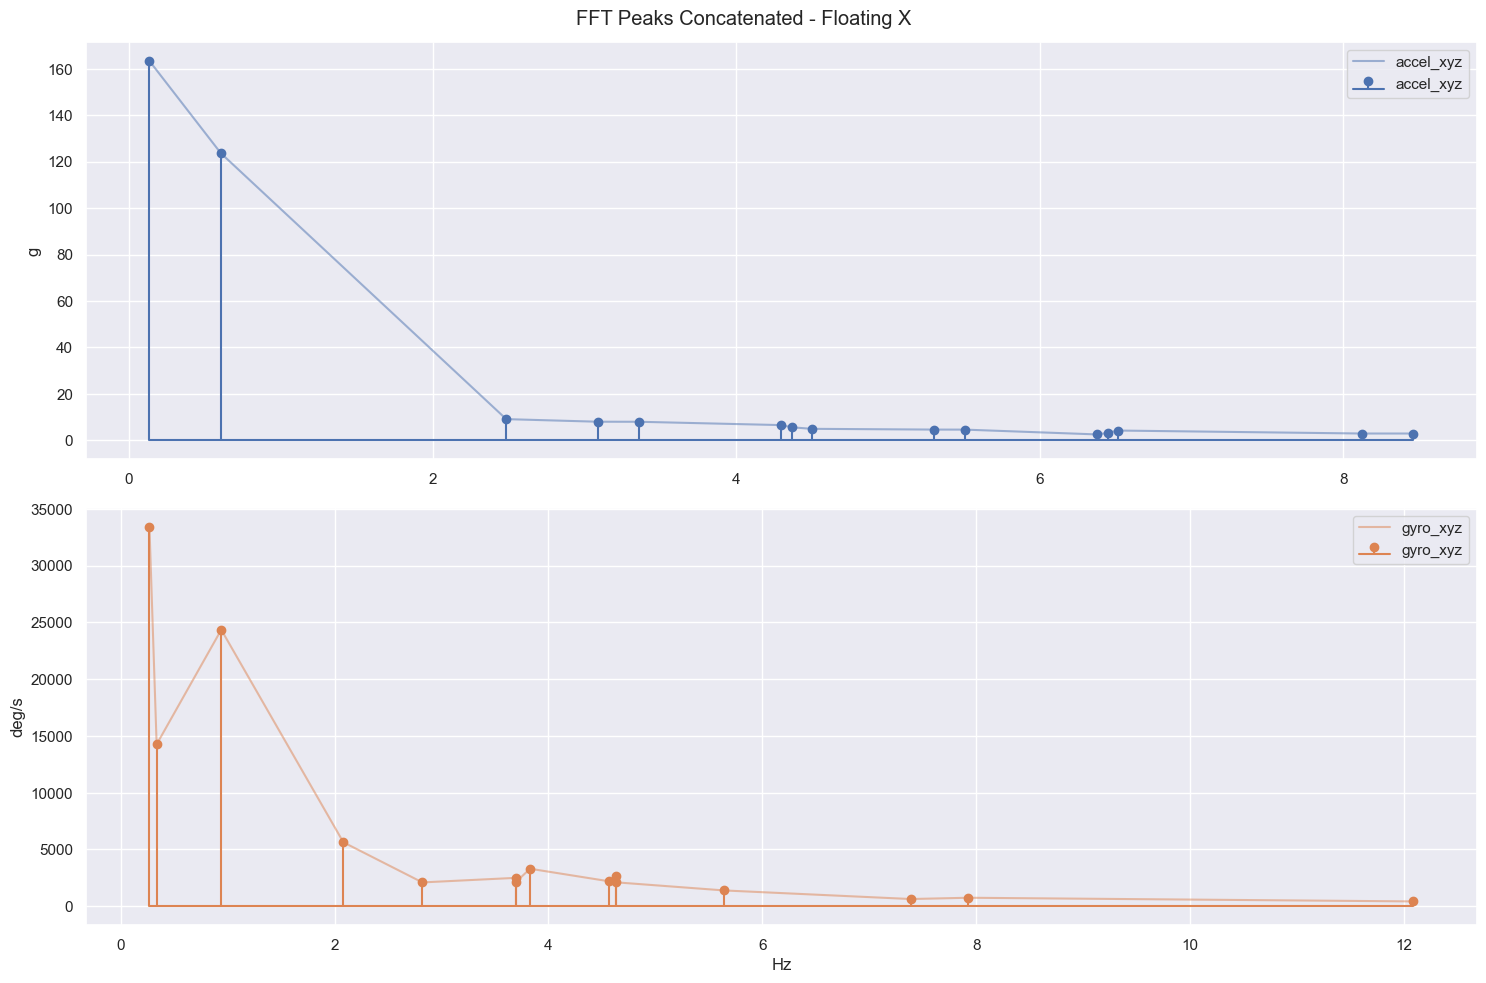

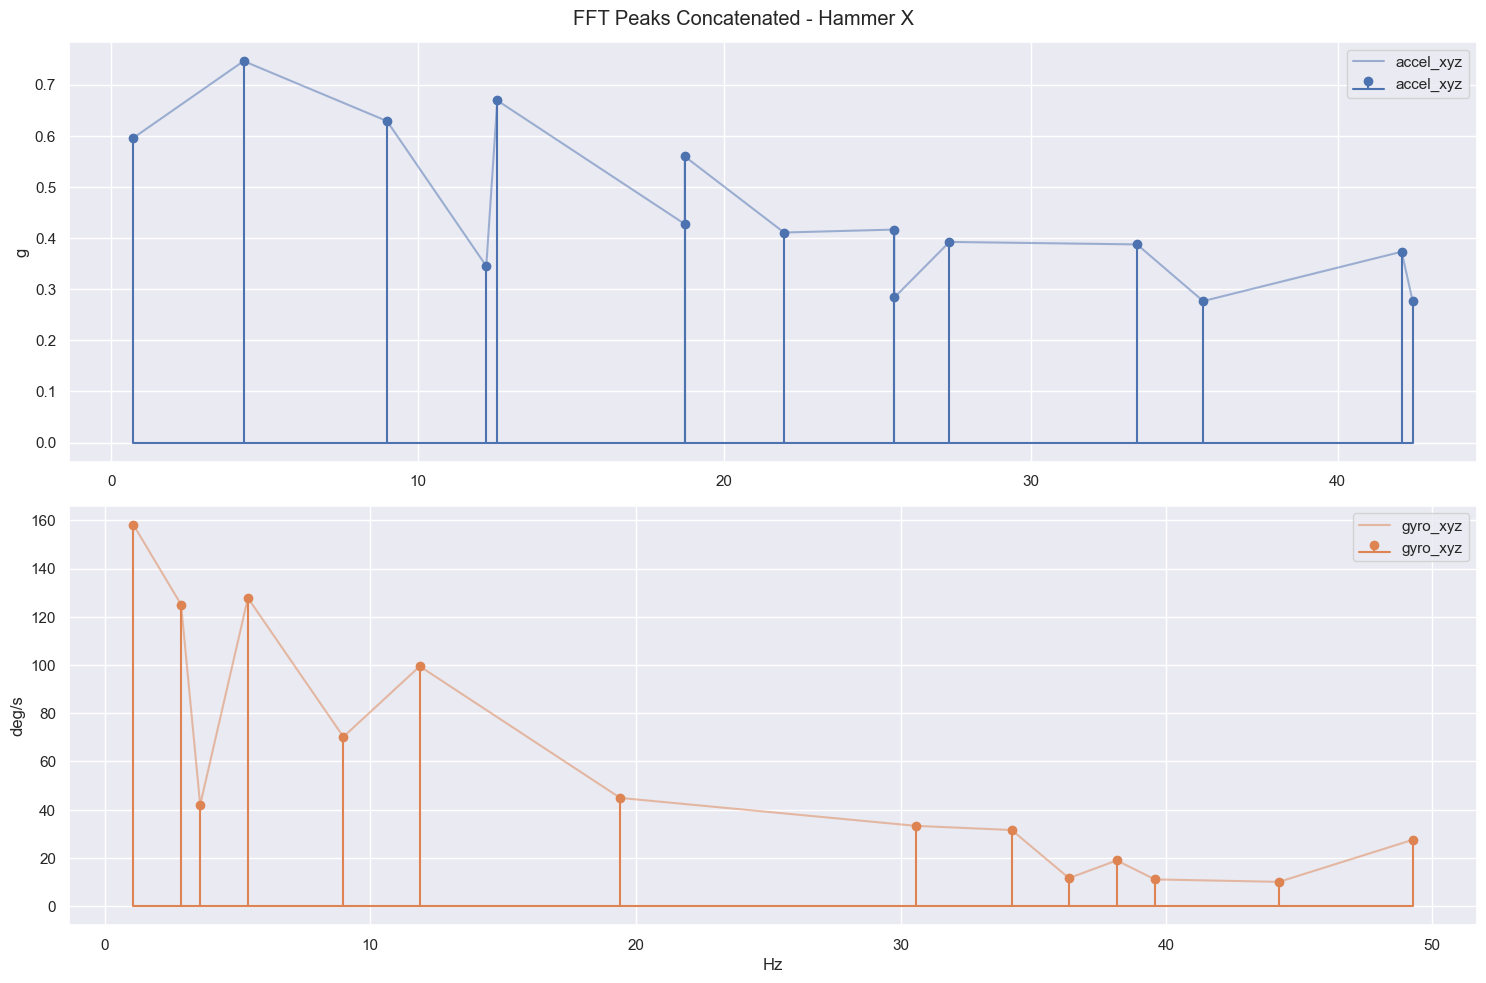

In [117]:
floatx_accel, floatx_gyro = plot_peaks_combined(floatingx_fft, title="Floating X")
hammerx_accel, hammerx_gyro = plot_peaks_combined(hammerx_fft, title="Hammer X")